# Simple Statistics without Statistics

*martin.topinka@gmail.com*

<img src="figures/topinka-brno.jpg" width="70%">

Heavily based on Jake Vanderplas's talk *Statistics for Hackers*

## Main theme:

- Statistics often looks **complicated** but using programming it can be **easy**.

- *If you can write a for-loop, you can do statistics*

We will apply Monte Carlo approach, which means a for loop and a random number generator

(Sorry, it will not be in R but in Python. You can convert it to any other programming language with just little overhead)

In *R* a for-loop may look like this...

```R
# Create a vector filled with random normal values
u1 <- rnorm(30)
print("This loop calculates the square of the first 10 elements of vector u1")

# Initialize `usq`
usq <- 0

for(i in 1:10) {
  # i-th element of `u1` squared into `i`-th position of `usq`
  usq[i] <- u1[i]*u1[i]
  print(usq[i])
}

print(i)
```

Statistics is all about **asking the right question**

<img src="figures/random-dilbert640.png">

In [51]:
# for loop in Python
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


### Table of content
1. Direct Monte Carlo simulation
2. Shuffling
3. Bootstrapping
4. Cross-validation

## Coin (textbook) example

Toss 30 times and get 22 heads. Is the coin fair?

- "a fair coin should show about 15 heads!"

- "gniaaah, even a fair coin could show 22 heads, just by chance, it's a random variable"

Classical method is to test the *Null hypothesis* (= basic, simple, zero complication hypothesis)

Q: What is the probability of a fair coin showing 22 heads in 30 tosses by chance?

$P(H) = 1/2$

$P(HH) = (1/2)^2$

$P(HHT) = (1/2)^3$



$P(2H, 1T) = P(HHT) + P(HTH) + P(THH) = 3/8$

...

Mr Bernoulli:

$P(N_H, N) = \binom{N}{N_H} p^{N_H} (1 - p)^{N - N_H}$

- $N_H$ number of heads, $N$ number of tosses
- number of arrangements
- $p$ probability of head, $p=0.5$ in this null hypothesis
- $p^{N_H}$ probability of $N$ heads
- $(1 - p)^{N - N_H}$ probability of $(N-N_H)$ tails
- probability of $N_H$ heads in $N$ tosses

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
np.random.seed(42)

In [4]:
import scipy.stats

In [5]:
# probability mass function
# binom.pmf(k) = choose(n, k) * p**k * (1-p)**(n-k)

[ n, p ] = [ 30, 0.5 ]
binom = scipy.stats.binom(n, p)
n_h = 22
print(binom.pmf(n_h))

0.005450961180031254


## The concept of p-value

<img src="figures/who_knows_pvalue.jpg" width="80%">

**Definition of p-value $\equiv$ Probability of obtaining a result equal or more exteme than that what was observed, if the null hypothesis is true.**

<img src="figures/pvalue.jpg" width="50%">

p-value does **not** calculate the probability that the null hypothesis is true. A high p-value means that our data is highly consistent with our null hypothesis, nothing more.

In [6]:
x = np.arange(1, n+1)
v_crit = binom.isf(0.05)
v_crit

19.0

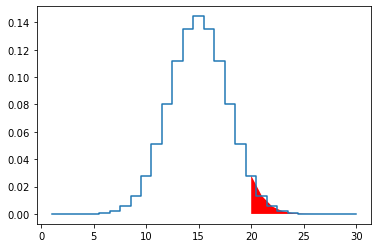

In [7]:
plt.step(x, binom.pmf(x), where='mid')
plt.fill_between(x[x>v_crit], binom.pmf(x)[x>v_crit], facecolor='red')
#plt.annotate('Integral is 0.8%',xy=(v_crit+2,0.03),color='red')

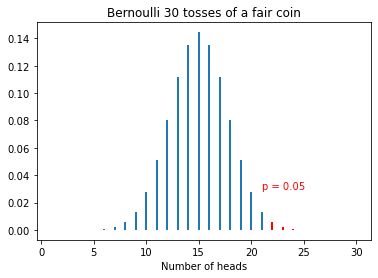

In [8]:
h = plt.vlines(x, 0, binom.pmf(x), lw=2)
plt.vlines(x[n_h-1:], 0, binom.pmf(x[n_h-1:]), color='red', lw=2)

plt.annotate('p = 0.05',xy=(v_crit+2,0.03),color='red')
plt.title('Bernoulli 30 tosses of a fair coin')
plt.xlabel('Number of heads');

In [9]:
pvalue = scipy.stats.binom_test((22,8), p=p) /2.
# division by 2 because the default is two sided, not one sided
# you can ommit /2 if  alternative='greater' is added
# distribution is symmetric
print(pvalue)

0.008062400855123993


In other words, the integral of the red area is 0.8%

In [10]:
scipy.stats.binom_test(22, 30, 0.5, alternative='greater')

0.008062400855123993

Probability 0.008 of this observation given a fair coin is smaller than $p < 0.05$. We say that we can **reject the fair coin hypothesis at $p = 0.05$ level**.

!!! Essential is the knowledge of the shape of the Bernoulli underlying distribution !!!

Interpretation requires understanding the doc/help...

In [11]:
1. - binom.cdf(21)
# As you can see, one has to read careful the man page
# what the parameters really are! 

0.008062400855123997

Is there an easier way?

### Simulate it!

In [12]:
M = 0
Ntrials = 10000
for i in range(Ntrials):
    trials = np.random.randint(2, size=30)
    if (trials.sum() >= 22):
        M += 1
p = M/np.float(Ntrials)
print(p)

0.0089


$\rightarrow$ reject fair coin at $p = 0.0089$. Work done.

Lesson learnt: Computing the sampling distribution is often hard, simulating the sampling distribution is often easier and more intuitive

## Is the difference between two groups of observations significant?

e.g. variability over a period of time

<img src="figures/two_sets.png">

In [13]:
A = np.array([84., 72., 57., 46., 63., 76., 99., 91.])
B = np.array([81., 69., 74., 61., 56, 87., 69., 65., 66., 44., 62., 69.])

NA = len(A)
NB = len(B)

In [14]:
muA, sigA = A.mean(), A.var(ddof=1)
muB, sigB = B.mean(), B.var(ddof=1)
diff = muA-muB
print("Mean A = %.1f"%muA)
print("Mean B = %.1f"%muB)
print("\nDifference A - B = %.1f\n"%(diff))
print("Sigma A = %.1f"%sigA)
print("Sigma B = %.1f"%sigB)

Mean A = 73.5
Mean B = 66.9

Difference A - B = 6.6

Sigma A = 316.3
Sigma B = 124.8


Is the difference in means 6.6 significant?

But what are the distributions?

Difference of two distributions follows *t distribution*

Welch's t-test...

$$t = \frac{ \bar{X_1} - \bar{X_2} } {\sqrt{\frac{s^2_1}{n_1} + \frac{s_2^2}{n_2}}}$$

In [15]:
def ttest(mu1, mu2, sig1, sig2, n1, n2):
    return (mu1 - mu2)/np.sqrt(sig1/n1 + sig2/n2)

In [16]:
t = ttest(muA, muB, sigA, sigB, NA, NB)
t

0.9316147771711583

Student t distribution

$$p(t, \nu) = \frac{ \Gamma \left( \frac{\nu + 1}{2}\right) } {\sqrt{\nu \pi} \Gamma \left(\frac{\nu}{2}\right)} \left( 1 + \frac{t^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

where $\nu$ is a degree of freedom... (Wiki definition d.o.f. $\equiv$ The number of independent ways by which a dynamic system can move wothout violating any constraint imposed on it)

$$\nu \approx \frac{\left( \frac{s_1^2}{N_1}+ \frac{s^2_2}{N_2}\right)^2}{\frac{s^4_1}{N_1^2(N_1-1)}+ \frac{s^4_2}{N_2^2(N_2 -1)}}$$

and $\Gamma$ is an extension of the factorial function (for integer $n$)
$\Gamma(n) = (n-1)!$ ...


$$\Gamma(t) = \int_0^\infty x^{t-1} \exp(-x) dx$$

<img src="figures/travolta.gif" width="50%">

In [17]:
def degof(s1, n1, s2, n2):
    return (s1/n1 + s2/n2)**2 / (s1**2/(n1**2 * (n1-1)) + s2**2/(n2**2 * (n2-1)) )

In [18]:
degof(sigA,NA, sigB, NB)

10.696428999751994

In [19]:
( sigA/NA + sigB/NB )**2 / ( ( sigA**2/(NA**2*(NA-1) ) + sigB**2/(NB**2*(NB-1))))

10.696428999751994

But what is the critical value for t-distribution for this $\nu$?

<img src="figures/tstat.png" width="100%">

In [20]:
pval = scipy.stats.t.ppf(0.95, 11)
print(pval)

1.7958848187036691


In [21]:
t_crit = 1.7959
t = 0.93 # remember from above?
t > t_crit

False

At this stage, we probably already forgot the initial question...

The critical value of the the t-distribution that controls the difference of means corresponding to the $p=0.05$ rejection level is $t_{crit}=1.7959$. Our t-student value is $t=0.93$.

$t < t_{crit}$, therefore the difference 6.6 is **not** significant at $p=0.05$ level...

<img src="figures/i-have-no-idea-what-im-doing.jpg" width="70%">

In [22]:
print(scipy.stats.ttest_ind(A, B, equal_var=False))
# be careful, the p-value is two-sided here, so we should divide it by 2

Ttest_indResult(statistic=0.9316147771711583, pvalue=0.3720857855465306)


In [23]:
from statsmodels.stats.weightstats import ttest_ind
t, p, dof = ttest_ind(A, B, alternative='larger', usevar='unequal')
print(p) # not smaller than 0.05

0.18604289277326536


Dark magic lies behind the sampling from the t-distribution.

It's the same as in the first coin example earlier, the answer lies in the sampling distribution

:-( Unfortunately, we cannot sample this time, because we don't know the underlying distributions of A and B

## Shuffling

Idea: **If the distributions are the same, shuffling -- changing the labels (A or B) --  will not change the statistics (mean). If the result is the same, the distributions are likely the same**

<img src="figures/two_sets.png" width="25%" align="right">

1. shuffle
2. rearrange
3. compute means and difference

Repeat steps 1. - 3. many times.

And check how many times out of all runs we were more extreme than our value:

$\frac{N_{> 6.6}}{N_{tot}} = 0.16$

Is 0.16 smaller than $p = 0.05$?

No. The difference of 6.6 is **not** significant at level $p=0.05$

We cannot reject the null hypothesis that the distributions are the same, shuffling data points does not matter.

In [24]:
AB = np.concatenate([A, B])
M = 0

N_trials = 10000
for i in range(N_trials):
    np.random.shuffle(AB)
    mu1 = AB[0:NA].mean()
    mu2 = AB[NA:].mean()
    diff = mu1 - mu2
    if (diff > 6.6):
        M = M +1
pvalue = M/np.float(Ntrials)
print(pvalue)
print(pvalue > 0.05) # True if no difference at p= 0.05 level

0.149
True


0.1558
True


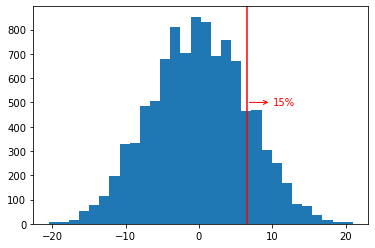

In [25]:
AB = np.concatenate([A, B])
M = 0

N_trials = 10000
results =  np.empty(N_trials)
for i in range(N_trials):
    np.random.shuffle(AB)
    mu1 = AB[0:NA].mean()
    mu2 = AB[NA:].mean()
    diff = mu1 - mu2
    results[i] = diff
    if (diff > 6.6):
        M = M +1
pvalue = M/np.float(Ntrials)
print(pvalue)
print(pvalue > 0.05) # True if no difference at p= 0.05 level
plt.hist(results, bins=30)
plt.axvline(x=6.6, color='red');
#  plt.annotate('p > %f'%pvalue,xy=(8,400),color='red')
plt.annotate(
    '%i%%'%(pvalue*100),
    color = 'red',
    xy=(6.6, 500),
    xycoords='data',
    xytext=(10, 500),
    textcoords='data',
    horizontalalignment='left',
    verticalalignment='center',
    arrowprops=dict(color='r', arrowstyle="<-")
);

Warning, it works only if:

- Null hypothesis assumes the two groups follow the same distribution
- samples are representative (be careful about selection biases)
- trials are independent
- the data are not ranked (ordered)

## Bootstrapping

In [26]:
sample = np.array([48, 24, 51, 12, 21, 41, 25, 23, 32, 61, 19, 24, 29, 21, 23, 13, 32, 18, 42, 18])

What is the mean?

What is the standard error of this mean?

$$\bar{x}=\frac{1}{N}\Sigma_{i=1}^{N} x_i$$

$$\sigma_\bar{x} = \frac{1}{\sqrt{N}}\sqrt{\frac{1}{N-1}}\Sigma_{i=1}^N (x_i - \bar{x})^2$$

In [27]:
# mean and the standard error of the mean
sample.mean(), scipy.stats.sem(sample, ddof=1)


(28.85, 2.970269348055829)

In [28]:
sample.std()   # Be careful, this is something completely different!!!

12.947103923271799

Again, we don't know the model

**The idea of Bootstrapping resampling: The data estimates its own distribution**

**Simulate the distribution by drawing samples from the sample itself with replacement**

1. draw a sample
2. calculate mean

Check the distribution of the means (compute the means of the means created this way)

In [29]:
Ntrials = 10000
xbar = np.empty(Ntrials)

N = sample.size

for i in range(Ntrials):
    new_sample = sample[np.random.randint(N, size=N)]
    xbar[i] = np.mean(new_sample)
    
print(xbar.mean(), xbar.std())

28.8363 2.905429023397405


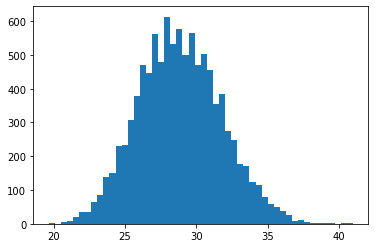

In [30]:
plt.hist(xbar, bins=50);

## Estimating uncertainty of fit paramters
Bootstrapping is often used to determine the uncertainity of fit parameters

In [31]:
x = np.array([ 7.5,  8.1,  8.4,  8.8,  8.9,
               9.0,  9.1,  9.2,  9.3,  9.5,
               9.6,  9.9, 10.0, 10.05, 10.5,
              10.6, 10.6, 11.2, 11.8, 12.6 ])

y = np.array([22, 21, 19, 16, 18,
              15, 17, 17, 17, 19,
              14, 14, 15, 11, 12,
              12, 13, 10,  7,  9])
assert(x.size  == y.size)
N = x.size
N

20

Slope:  -2.969429344938822
Intersect: 43.79997109961708


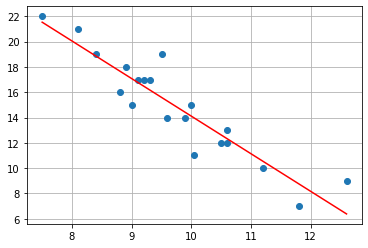

In [32]:
plt.plot(x,y,"o")
plt.grid(True)
slope, intersect = np.polyfit(x,y, 1)
plt.plot(x,slope*x+intersect,'-r')
print("Slope: ", slope)
print("Intersect:", intersect)

In [33]:
from scipy.stats import linregress
linreg = linregress(x,y)
print("Slope:", linreg.slope)
print("Intersect:", linreg.intercept)
print("Std Error:", linreg.stderr)

Slope: -2.969429344938821
Intersect: 43.79997109961707
Std Error: 0.28981087982123505


!!! But this is the error of the fit. Not the error of the paramters !!!

What is the error of each parameter?

In [34]:
results = np.empty((10000,2))
for i in range(10000):
    ind = np.random.randint(N, size=N)
    slope, intercept = np.polyfit(x[ind],y[ind], 1)
    results[i][0], results[i][1] = slope, intercept

In [35]:
print("Slope:", results[:,0].mean(), '+/-', results[:,0].std())

Slope: -3.013191433579877 +/- 0.3204121375249993


In [36]:
print("Intercept:", results[:,1].mean(), '+/-', results[:,1].std())

Intercept: 44.199365860801315 +/- 3.050190452831111


Warnings:

- Bootstrapping does not work for only few samples (N<20)
- Be careful about biases

## Cross validation

Some of you may know about this from Machine Learning already

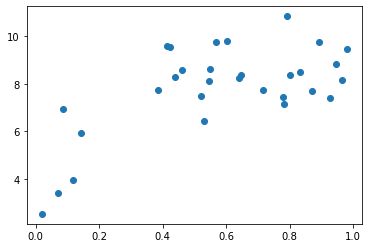

In [37]:
import numpy as np

np.random.seed(0)
true_fun = lambda X: 10 - 1. / (X + 0.1)

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
#    rng = np.random.RandomState(rseed)
    X = np.sort(np.random.rand(N))
    X = X[:, np.newaxis]
    #X = np.sort(rng.rand(N, 1))
    y = true_fun(X.ravel())
    if err > 0:
        y += err * 1.*np.random.randn(N)
    return X, y

N = 30
X, y = make_data(N)
plt.scatter(X.ravel(), y);

### Which model is a better fit?

$y = a + b x$

$y = a + b x + c x^2$

or higher polynomial?

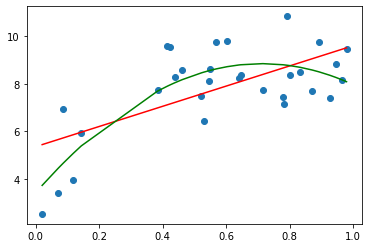

In [38]:
z1 = np.polyfit(X.ravel(), y, 1)
f1 = np.poly1d(z1)
y_new = f1(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')

z2 = np.polyfit(X.ravel(), y, 2)
f2 = np.poly1d(z2)
y_new = f2(X.ravel())
plt.plot(X.ravel(), y_new, color='green')

- measure of error is rms (root of sum of squared errors)
- but more flexible models will always have lower RMS error

In [39]:
def rms(y_real, y_predicted):
    return np.sqrt(np.mean( (y_real-y_predicted)**2) )

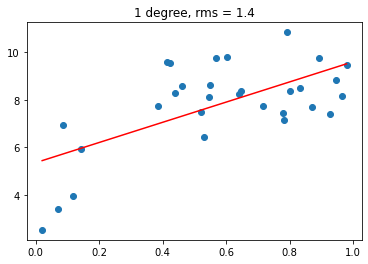

In [40]:
z1 = np.polyfit(X.ravel(), y, 1)
f1 = np.poly1d(z1)
y_new = f1(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')
plt.title('1 degree, rms = %.1f'%rms(y, y_new));

In [41]:
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

rms1 = sqrt(mean_squared_error(y, y_new))
rms1

1.4167738123934264

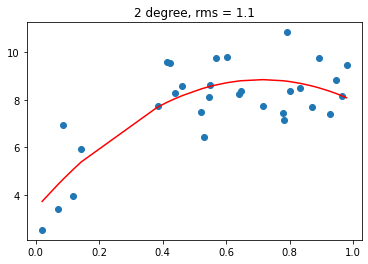

In [42]:
z2 = np.polyfit(X.ravel(), y, 2)
f2 = np.poly1d(z2)
y_new = f2(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')
plt.title('2 degree, rms = %.1f'%rms(y, y_new));

In [43]:
rms2 = sqrt(mean_squared_error(y, y_new))
rms2

1.134207969060934

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

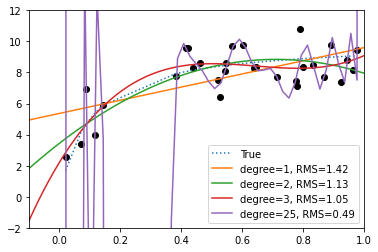

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 2*N)[:, None]

plt.scatter(X.ravel(), y, color='black')
plt.plot(X.ravel(), true_fun(X.ravel()), label='True', linestyle=":")

axis = plt.axis()
for degree in [1, 2, 3, 25]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    y_fool = PolynomialRegression(degree).fit(X, y).predict(X)
    rms_val = rms(y, y_fool)
#    scores = cross_validation.cross_val_score(PolynomialRegression(degree),
#        X, y, scoring="mean_squared_error", cv=cv)
    plt.plot(X_test.ravel(), y_test, label='degree={0}, RMS={1:.2f}'.format(degree, rms_val))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The difference in mean squared error follows chi-square distribution

$$\chi^2(x, \nu) = \frac{1}{2^{\nu/2}\Gamma \left(\frac{\nu}{2}\right)} x ^{\frac{\nu}{2}-1} \exp \left({-\frac{1}{2}x}\right)$$

$\nu \approx \nu_2 - \nu_1$

$\nu_2 \approx (N - d_2)$

$\nu_1 \approx (N - d_1)$

models are nested, therefore one can estimate degrees of freedom easily

<img src="figures/help.gif">

**Cross-validation idea:**

1. Split data **randomly** in two sets
2. Fit data in each half
3. Use the model and calculate the rms for the other half and vice versa
4. Compare rms and cross-validated rms

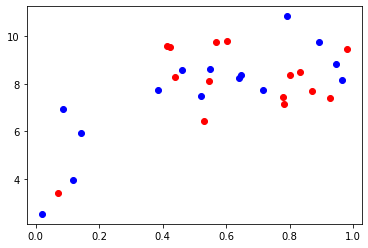

In [46]:
ind = np.arange(N)
np.random.shuffle(ind) # shuffle in place
ind
plt.scatter(X[ind[:N//2]].ravel(), y[ind[:N//2]], color='red')
plt.scatter(X[ind[N//2:]].ravel(), y[ind[N//2:]], color='blue')

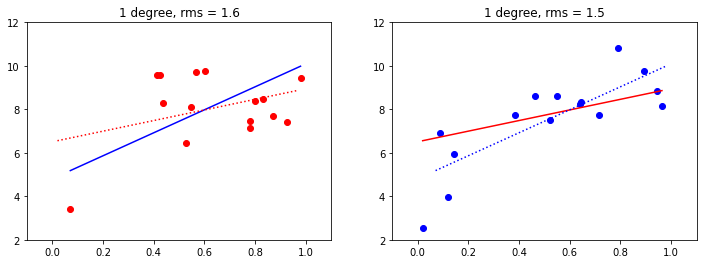

In [47]:
degree = 1

X1 = X[ind[:N//2]].ravel()
y1 = y[ind[:N//2]]
sind1 = X1.argsort()
X1 = X1[sind1]
y1 = y1[sind1]

z1 = np.polyfit(X1, y1, degree)
f1 = np.poly1d(z1)
y_new1 = f2(X1)

X2 = X[ind[N//2:]].ravel()
y2 = y[ind[N//2:]]
sind2 = X2.argsort()
X2 = X2[sind2]
y2 = y2[sind2]

z2 = np.polyfit(X2, y2, degree)
f2 = np.poly1d(z2)

y_new1 = f2(X1)
y_new2 = f1(X2)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(X1, y1, color='red');
plt.plot(X1, y_new1, color='blue')
plt.plot(X2, y_new2, ":",color='red')
plt.title('%i degree, rms = %.1f'%(degree, rms(y1, y_new1)))
plt.xlim(-0.1,1.1)
plt.ylim(2,12)
plt.subplot(122)
plt.scatter(X2, y2, color='blue');
plt.plot(X2, y_new2, color='red')
plt.plot(X1, y_new1, ":",color='blue')
plt.xlim(-0.1,1.1)
plt.ylim(2,12)
plt.title('%i degree, rms = %.1f'%(degree, rms(y2, y_new2)));

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

cv = KFold(N, n_splits=2, shuffle=True, random_state=1)

degree = np.arange(1, 10)
                       
train_score, val_score = validation_curve(PolynomialRegression(),
                                          X, y,
                                          param_name='polynomialfeatures__degree',
                                          param_range=degree,
                                          scoring=make_scorer(rms),
                                          cv=cv,
                                         )

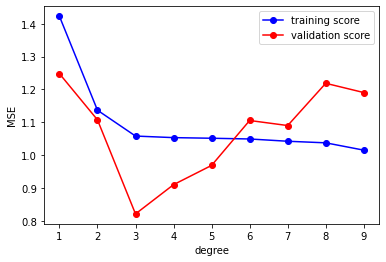

In [49]:
plt.plot(degree, np.median(train_score, 1), "o-", color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), "o-", color='red', label='validation score')
plt.legend(loc='best')
#plt.ylim(-1, 1)
plt.xlabel('degree')
plt.ylabel('MSE');

**Best model minimises the cross-validated error**

<img src="figures/under-overfitting.png" width="75%" align="left">

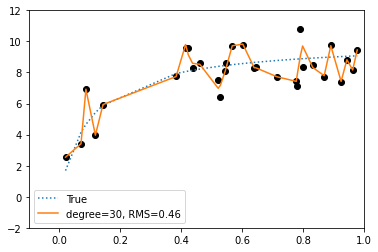

In [50]:
X_test = np.linspace(-0.1, 1.1, 2*N)[:, None]

plt.scatter(X.ravel(), y, color='black')
plt.plot(X.ravel(), true_fun(X.ravel()), label='True', linestyle=":")

degree = 30
y_fool = PolynomialRegression(degree).fit(X, y).predict(X)
rms_val = rms(y, y_fool)
plt.plot(X.ravel(), y_fool, label='degree={0}, RMS={1:.2f}'.format(degree, rms_val))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Cross-validation is independent of the used model.

You need a "reasonable" number of data points

!!! Cross validation is often the only choice in machine learning, because the statistics of the models are typically not known !!!

k-fold cross-validation is often used.
<img src="figures/kfold-cv.png" width="60%">

## Summary

- Sometimes the questions are complicated but the answers  are simple
- If you can write a for-loop you can do statistical analysis

1. Direct simulation (to compare p-value and extremes)
2. Shuffling (to test if two samples are drawn from the same distribution)
3. Bootstrapping (for  uncertainty of fit parameters)
4. Cross-validation (for choosing a better model)


<img src="figures/wumo3.jpg">